<a href="https://colab.research.google.com/github/deltorobarba/finance/blob/main/black_litterman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Black Litterman Model**

> Adjusts asset weights based on investor views and equilibrium returns for more stable portfolio optimization.

The Black-Litterman Model is often used for portfolio optimization, where it combines the market equilibrium returns (from CAPM) with investor's subjective views.

In [1]:
!pip install yfinance PyPortfolioOpt -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.8 MB/s eta 0:00:00


[*********************100%***********************]  5 of 5 completed


Optimized Portfolio Weights:
 OrderedDict([('AAPL', 0.50078), ('AMZN', 0.49922), ('GOOG', 0.0), ('MSFT', 0.0), ('TSLA', 0.0)])
Expected annual return: 15.5%
Annual volatility: 34.7%
Sharpe Ratio: 0.39


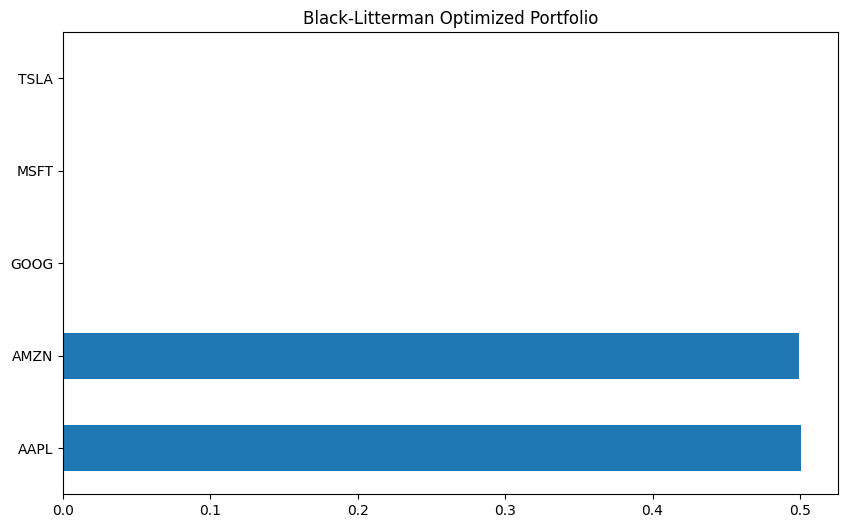

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from pypfopt.black_litterman import BlackLittermanModel, market_implied_risk_aversion
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns

# Step 1: Download historical price data
tickers = ["AAPL", "MSFT", "GOOG", "AMZN", "TSLA"]
data = yf.download(tickers, start="2020-01-01", end="2023-01-01")['Adj Close']

# Step 2: Calculate the expected returns and the covariance matrix using historical data
mu = expected_returns.mean_historical_return(data)
S = risk_models.sample_cov(data)

# Step 3: Get the market cap weights (for equilibrium market returns)
market_caps = {
    "AAPL": 2.41e12,  # Example market caps in USD
    "MSFT": 2.15e12,
    "GOOG": 1.78e12,
    "AMZN": 1.55e12,
    "TSLA": 0.9e12
}
market_weights = np.array([market_caps[ticker] for ticker in tickers])
market_weights /= market_weights.sum()

# Step 4: Calculate the market risk aversion (lambda) parameter
delta = market_implied_risk_aversion(data)

# Step 5: Formulate your views (P matrix) and confidence (Q vector)
# Example views:
# View 1: You believe AAPL will outperform the market by 2%
# View 2: You believe TSLA will underperform the market by 1%
P = np.array([
    [1, 0, 0, 0, 0],  # AAPL outperform market
    [0, 0, 0, 0, -1]  # TSLA underperform market
])
Q = np.array([0.02, -0.01])

# Step 6: Implement the Black-Litterman Model
bl = BlackLittermanModel(S, pi=market_weights, P=P, Q=Q, omega="idzorek", view_confidences=[0.5, 0.6])
bl_return = bl.bl_returns()

# Step 7: Optimize the portfolio with the new returns
ef = EfficientFrontier(bl_return, S)
weights = ef.max_sharpe()

# Step 8: Show the weights and plot the portfolio performance
cleaned_weights = ef.clean_weights()
print("Optimized Portfolio Weights:\n", cleaned_weights)

# Plotting the portfolio performance (optional)
ef.portfolio_performance(verbose=True)

# Step 9: Visualize the portfolio allocation
pd.Series(cleaned_weights).plot(kind="barh", title="Black-Litterman Optimized Portfolio", figsize=(10,6))
plt.show()

1. **Download historical data**: We're using `yfinance` to download the adjusted closing prices for a sample set of stocks.
   
2. **Calculate returns and covariance**: We calculate the expected returns using historical mean returns and compute the covariance matrix using the sample covariance.

3. **Market equilibrium weights**: The market capitalization of each stock is used to calculate the equilibrium market weights. These represent the neutral "market view."

4. **Market risk aversion**: This parameter is necessary for the Black-Litterman model, and it's estimated from historical data.

5. **Investor views (P and Q)**: Here, we define views on two assets—AAPL will outperform the market by 2%, and TSLA will underperform by 1%. These views are expressed using the matrix `P` and the vector `Q`.

6. **Black-Litterman returns**: We use the `BlackLittermanModel` to compute the posterior expected returns, combining market equilibrium and investor views.

7. **Portfolio optimization**: The Efficient Frontier is optimized using the Black-Litterman expected returns, with the goal of maximizing the Sharpe ratio.

8. **Visualization**: We visualize the optimized portfolio allocation.